Given a raw video, automatically segment it into distinct temporal phases
without labels, without training.


In [ ]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from torchvision import models, transforms
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
video_path = "/content/784-139519770_small.mp4"

cap = cv2.VideoCapture(video_path)

frames = []
frame_ids = []

frame_rate = 5  # take 1 frame every 5 frames
idx = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if idx % frame_rate == 0:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
        frame_ids.append(idx)

    idx += 1

cap.release()

print(f"Total sampled frames: {len(frames)}")


Total sampled frames: 135


In [ ]:
resnet = models.resnet50(pretrained=True)
resnet.fc = torch.nn.Identity()
resnet = resnet.to(device)
resnet.eval()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
embeddings = []

with torch.no_grad():
    for frame in frames:
        img = Image.fromarray(frame)
        img_tensor = transform(img).unsqueeze(0).to(device)
        feat = resnet(img_tensor)
        embeddings.append(feat.cpu().numpy().flatten())

embeddings = np.array(embeddings)

print("Embedding shape:", embeddings.shape)


Embedding shape: (135, 2048)


In [ ]:
similarities = []

for i in range(len(embeddings) - 1):
    sim = cosine_similarity(
        embeddings[i].reshape(1, -1),
        embeddings[i+1].reshape(1, -1)
    )[0][0]
    similarities.append(sim)


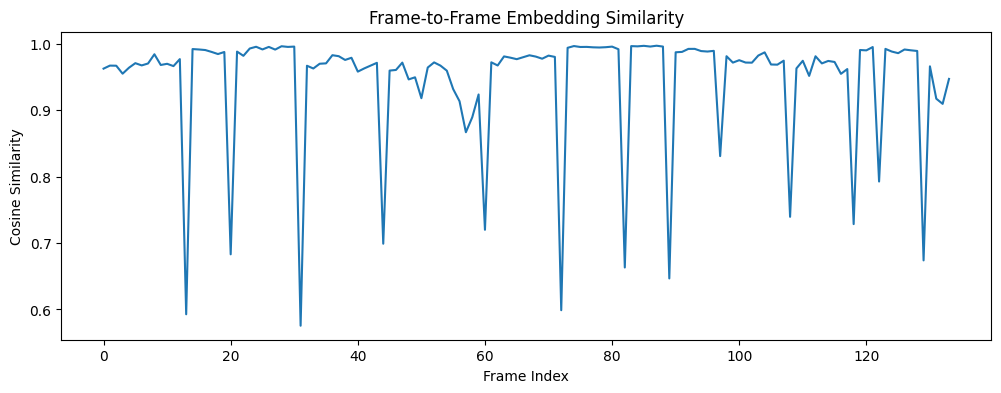

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(similarities)
plt.xlabel("Frame Index")
plt.ylabel("Cosine Similarity")
plt.title("Frame-to-Frame Embedding Similarity")
plt.show()


In [ ]:
threshold = np.mean(similarities) - 2*np.std(similarities)

change_points = [i for i, s in enumerate(similarities) if s < threshold]

print("Detected change points:", change_points)


Detected change points: [13, 20, 31, 44, 60, 72, 82, 89, 108, 118, 129]


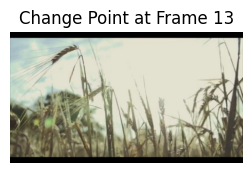

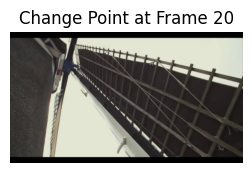

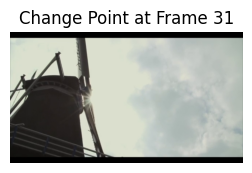

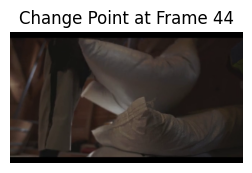

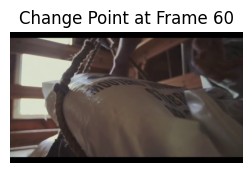

In [ ]:
for cp in change_points[:5]:
    plt.figure(figsize=(3,3))
    plt.imshow(frames[cp])
    plt.title(f"Change Point at Frame {cp}")
    plt.axis("off")
    plt.show()


The frame-to-frame embedding similarity plot exhibits sharp drops at multiple time indices,
indicating potential scene transitions.

Visual inspection of detected change points confirms that these correspond to
semantic shifts in the video, such as changes in viewpoint, dominant objects,
and environmental context (e.g., outdoor grass → windmill structure → sky-facing views → interior machinery).

This demonstrates that pretrained CNN embeddings encode high-level visual semantics
that remain consistent within a segment and change abruptly across different phases,
even without supervision or task-specific training.


  KEY OBSERVATIONS
- Frames within the same semantic phase show high embedding similarity.
- Sharp similarity drops align with visually meaningful transitions.
- Temporal structure emerges without labels, annotations, or fine-tuning.
- CNN embeddings capture scene-level semantics beyond low-level motion cues.


INTERPRETATION
These results suggest that pretrained image models implicitly learn representations
that can be repurposed for temporal reasoning tasks, such as unsupervised video segmentation.
Simple similarity-based methods are sufficient to recover meaningful structure from raw video.
